In [131]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import itertools
sys.path.append("/mnt/ssd/NMRlipids_VI-NewIonModel/scripts/")
import calcOrderParameters as cop
import fnmatch
import re
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [132]:
def locate(pattern, root=os.curdir):
    '''Locate all files matching supplied filename pattern in and below
    supplied root directory.'''
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            yield os.path.join(path, filename)
            

In [133]:
class Simulation():
    '''Simulation class stores simulation data relevant for NMRlipids project 6'''
    def __init__(self, dirname, 
                 ordpars_fname="OrdPars.dat", 
                 dens_fname="density_ca_cl_water.xvg", 
                 conc_bulk_fname="conc_ion_bulk_mmolL.dat", 
                 conc_nominal_fname="conc_ion_nominal_mmolL.dat"):
        self.dirname = dirname
        self.ordpars = cop.parse_op_input(os.path.join(dirname, ordpars_fname))
        try:
            self.dens    = np.loadtxt(os.path.join(dirname, dens_fname))
            self.conc_bulk = np.loadtxt(os.path.join(dirname, conc_bulk_fname))
            self.conc_nominal = np.loadtxt(os.path.join(dirname, conc_nominal_fname))
        except:
            print "Simulation in \n {d} \n has no densities or files with concentrations, setting concentrations to 0.".format(d=self.dirname)
            self.conc_bulk = np.zeros([2])
            self.conc_nominal = 0.0
                    

Finding all simulations with ECC-lipids and cationic surfactant

In [134]:
sim_dirs = []
for f in locate("OrdPars.dat", root=os.curdir+"/NpT"):
    if "sim22a_" in f and "SPCE" in f and "mM_NaCl" in f and not "MODEL_LIPID14" in f:
        sim_dirs.append(os.path.dirname(f))

for f in sim_dirs:
    if "300K" in f:
        sim_dirs.remove(f)
        
sim_dirs.sort()
#print sim_dirs

In [135]:
sims = []
for d in sim_dirs:
    sim = Simulation(d)
    sims.append(sim)

Simulation in 
 /mnt/ssd/NMRlipids_VI-NewIonModel/simulations/POPC/lipid14/NpT/sim22a_0mM_NaCl_SPCE_non-tail-atoms_q-sc_0.80_sig-sc_0.89_noIons-ref 
 has no densities or files with concentrations, setting concentrations to 0.


getting PN_vector data from ECC-lipids simulations

In [136]:
opsdata = {}
# regular expressions explained at https://docs.python.org/2/howto/regex.html#match-versus-search
p = re.compile('\d+p_')  # string pattern for molar fraction in %
for s in sims:
    if "T7H" in s.dirname:
        m = p.search(s.dirname)
        s.conc_bulk[0] = float(m.group()[0:2])
    for opname in ["alpha1", "alpha2", "beta1", "beta2", "PN_vector", "g3_1", "g3_2"]:
        temp_list = []
        try:
            temp_list.append([s.conc_bulk[0], float(s.ordpars[opname].avg)])
            print s.conc_bulk[0], float(s.ordpars[opname].avg), float(s.ordpars[opname].errest)
        except:
            print "Simulation in dir \n {d} \n seem to have no record of the order parameter {op} -- skipping".format(d=s.dirname, op=opname)
        if opname in opsdata.keys():
            opsdata[opname].extend(temp_list)
        else:
            opsdata[opname] = temp_list
            

print opsdata

0.0 0.01437 0.00111
0.0 0.01381 0.00111
0.0 -0.04397 0.00106
0.0 -0.043 0.00107
0.0 71.78102 0.07989
0.0 -0.16853 0.00088
0.0 -0.18646 0.00082
1019.22129568 0.00149 0.00098
1019.22129568 0.00296 0.00098
1019.22129568 -0.04872 0.00093
1019.22129568 -0.0517 0.00093
1019.22129568 70.45796 0.07269
1019.22129568 -0.14794 0.0008
1019.22129568 -0.17045 0.00074
{'alpha2': [[0.0, 0.01381], [1019.22129568, 0.00296]], 'alpha1': [[0.0, 0.01437], [1019.22129568, 0.00149]], 'g3_2': [[0.0, -0.18646], [1019.22129568, -0.17045]], 'g3_1': [[0.0, -0.16853], [1019.22129568, -0.14794]], 'beta2': [[0.0, -0.043], [1019.22129568, -0.0517]], 'beta1': [[0.0, -0.04397], [1019.22129568, -0.04872]], 'PN_vector': [[0.0, 71.78102], [1019.22129568, 70.45796]]}


Redoing the file search again for the reference simulations set (i.e. Lipid14 + Aqvist ions)

In [137]:
#REUSING sim_dirs!!
sim_dirs = []
for f in locate("OrdPars.dat", root=os.curdir+"/NpT"):
    if "sim0_ref_noIons" in f:
        sim_dirs.append(os.path.dirname(f))
    if "sim0-3_" in f and "NaCl_Aqvist" in f:
        sim_dirs.append(os.path.dirname(f))

sim_dirs.sort()
#print sim_dirs

sims_l14 = []
for d in sim_dirs:
    sim = Simulation(d)
    sims_l14.append(sim)

Simulation in 
 /mnt/ssd/NMRlipids_VI-NewIonModel/simulations/POPC/lipid14/NpT/sim0_ref_noIons 
 has no densities or files with concentrations, setting concentrations to 0.


getting PN_vector data from Lipid14 simulations

In [138]:
opsdata_l14 = {}
# regular expressions explained at https://docs.python.org/2/howto/regex.html#match-versus-search
#p = re.compile('\d+molF')  # string pattern for molar fraction in %
for s in sims_l14:
    for opname in ["alpha1", "alpha2", "beta1", "beta2", "PN_vector", "g3_1", "g3_2"]:
        temp_list = []
        try:
            temp_list.append([s.conc_bulk[0], float(s.ordpars[opname].avg)])
            print s.conc_bulk[0], float(s.ordpars[opname].avg), float(s.ordpars[opname].errest)
        except:
            print "Simulation in dir \n {d} \n seem to have no record of the order parameter {op} -- skipping".format(d=s.dirname, op=opname)
        if opname in opsdata_l14.keys():
            opsdata_l14[opname].extend(temp_list)
        else:
            opsdata_l14[opname] = temp_list
            

print opsdata_l14

983.75820598 0.05443 0.00296
983.75820598 0.07123 0.00298
983.75820598 -0.01214 0.00284
983.75820598 -0.00634 0.00287
983.75820598 75.0228 0.20538
983.75820598 -0.16087 0.00215
983.75820598 -0.2437 0.00181
0.0 0.06928 0.00077
0.0 0.07021 0.00076
0.0 -0.00241 0.00073
0.0 0.00048 0.00073
0.0 76.79575 0.05124
0.0 -0.17378 0.00055
0.0 -0.23514 0.00049
{'alpha2': [[983.75820597999996, 0.07123], [0.0, 0.07021]], 'alpha1': [[983.75820597999996, 0.05443], [0.0, 0.06928]], 'g3_2': [[983.75820597999996, -0.2437], [0.0, -0.23514]], 'g3_1': [[983.75820597999996, -0.16087], [0.0, -0.17378]], 'beta2': [[983.75820597999996, -0.00634], [0.0, 0.00048]], 'beta1': [[983.75820597999996, -0.01214], [0.0, -0.00241]], 'PN_vector': [[983.75820597999996, 75.0228], [0.0, 76.79575]]}


Locating and loading Lipid14 + Dang ions simulations

In [139]:
#REUSING sim_dirs!!
sim_dirs = []
for f in locate("OrdPars.dat", root=os.curdir+"/NpT"):
    if "sim1_" in f or "sim0_ref_noIons" in f:
        sim_dirs.append(os.path.dirname(f))

sim_dirs.sort()
print sim_dirs

sims_l14d = []
for d in sim_dirs:
    sim = Simulation(d)
    sims_l14d.append(sim)

['/mnt/ssd/NMRlipids_VI-NewIonModel/simulations/POPC/lipid14/NpT/sim0_ref_noIons', '/mnt/ssd/NMRlipids_VI-NewIonModel/simulations/POPC/lipid14/NpT/sim1_843mM_NaCl_Dang_ref']
Simulation in 
 /mnt/ssd/NMRlipids_VI-NewIonModel/simulations/POPC/lipid14/NpT/sim0_ref_noIons 
 has no densities or files with concentrations, setting concentrations to 0.


In [140]:
opsdata_l14d = {}
# regular expressions explained at https://docs.python.org/2/howto/regex.html#match-versus-search
#p = re.compile('\d+molF')  # string pattern for molar fraction in %
for s in sims_l14d:
    if "molF" in s.dirname:
        m = p.search(s.dirname)
        s.conc_bulk[0] = float(m.group()[0:2])
    for opname in ["alpha1", "alpha2", "beta1", "beta2", "PN_vector", "g3_1", "g3_2"]:
        temp_list = []
        try:
            temp_list.append([s.conc_bulk[0], float(s.ordpars[opname].avg)])
            print s.conc_bulk[0], float(s.ordpars[opname].avg), float(s.ordpars[opname].errest)
        except:
            print "Simulation in dir \n {d} \n seem to have no record of the order parameter {op} -- skipping".format(d=s.dirname, op=opname)
        if opname in opsdata_l14d.keys():
            opsdata_l14d[opname].extend(temp_list)
        else:
            opsdata_l14d[opname] = temp_list
            

print opsdata_l14d

0.0 0.06928 0.00077
0.0 0.07021 0.00076
0.0 -0.00241 0.00073
0.0 0.00048 0.00073
0.0 76.79575 0.05124
0.0 -0.17378 0.00055
0.0 -0.23514 0.00049
580.557940199 0.03807 0.00075
580.557940199 0.04029 0.00075
580.557940199 -0.01741 0.00072
580.557940199 -0.01621 0.00073
580.557940199 73.72057 0.05519
580.557940199 -0.16458 0.00057
580.557940199 -0.22282 0.00051
{'alpha2': [[0.0, 0.07021], [580.55794019899997, 0.04029]], 'alpha1': [[0.0, 0.06928], [580.55794019899997, 0.03807]], 'g3_2': [[0.0, -0.23514], [580.55794019899997, -0.22282]], 'g3_1': [[0.0, -0.17378], [580.55794019899997, -0.16458]], 'beta2': [[0.0, 0.00048], [580.55794019899997, -0.01621]], 'beta1': [[0.0, -0.00241], [580.55794019899997, -0.01741]], 'PN_vector': [[0.0, 76.79575], [580.55794019899997, 73.72057]]}


getting experimental results from Scherer89

In [141]:
exp_filenames = []
experiments = {}
freq_to_scd = 0.00748
# find files with the experimental values as read from figure4 in scherer89
for f in locate("EXP-Akutsu*NaClchange.dat", root=os.curdir+"/../../../../lipid_ionINTERACTION/"):
    exp_filenames.append(f)
    
exp_data = np.loadtxt(exp_filenames[0], dtype=str)
# convert col1 to contain S_CD with a correct sign -- this is specific to these data
# convert col0 to contain concentrations in %-unit
experiments['beta']  = exp_data[:,0:-1]
experiments['alpha'] = exp_data[:,[0,2]]
for key in experiments.keys():
    templist = []
    for item in experiments[key]:
        if not item[1]=='-':
            fitem = np.array(item, dtype=float)
            freq_sign = 1.0
            if 'beta' in key:
                freq_sign = -1.0
            templist.append([fitem[0]*1.0, fitem[1]*freq_to_scd*freq_sign])
    experiments[key] = np.array(templist, dtype=float)
    
print experiments
        

{'alpha': array([[  0.00000000e+00,   0.00000000e+00],
       [  1.05000000e+03,  -5.61000000e-03]]), 'beta': array([[  0.00000000e+00,  -0.00000000e+00],
       [  1.05000000e+03,  -2.24400000e-03]])}


# Plotting figure 1: PN_vector and order parameters $\alpha$ and $\beta$ depend on the amount of bound charge - cationic surfactant

# Plotting figure 2: PN_vector and order parameters $\alpha$, $\beta$, and $g_3$ depend on the amount of bound charge - cationic surfactant

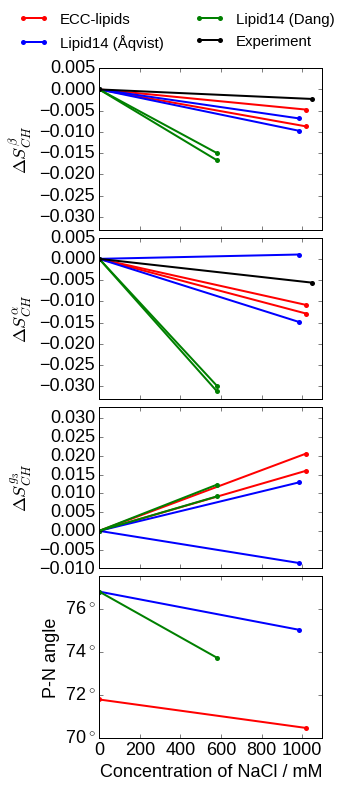

In [145]:
font = {'family' : 'Liberation Sans',
        'style'  : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, axs = plt.subplots(nrows=4, ncols=1, sharex="all", figsize=[4,12], dpi=200)
fig.subplots_adjust(hspace=0.05)
#fig.subplotpars.left = 0.3

# give subplots human-redable names
dsa = axs[1] # Delta S alpha
dsb = axs[0] # Delta S beta
dsg = axs[2] # Delta S g_3
pna = axs[3] # PN_vector

# add some text for labels, title and axes ticks
pna.set_xlabel(r'Concentration of NaCl / mM')
pna.set_ylabel(r'P-N angle')
dsa.set_ylabel(r'$\Delta S_{CH} ^{\alpha}$')
dsb.set_ylabel(r'$\Delta S_{CH} ^{\beta}$')
dsg.set_ylabel(r'$\Delta S_{CH} ^{g_3}$')

#pna.set_xlim([0.0,60.0])
#ax.set_xticks(r1)
#xlabelsl = list(xlabels)
#xlabelsl.extend(range(2, 18))
#ax.set_xticklabels(xlabelsl, rotation=0)

for (opsplot, c, label) in zip([opsdata, opsdata_l14, opsdata_l14d, experiments], 
                               ["red", "blue", "green", "black"], 
                               ["ECC-lipids", ur"Lipid14 (\u00c5qvist)", "Lipid14 (Dang)", "Experiment"]):
    for key in opsplot.keys():
        yerror = 0.001
        do_delta = False
        if key.startswith("alpha"):
            iplt = 1
            do_delta = True
            ylim = [-0.033, 0.005]
        elif key.startswith("beta"):
            iplt = 0
            do_delta = True
            ylim = [-0.033, 0.005]
        elif key.startswith("g3"):
            iplt = 2
            do_delta = True
            ylim = [-0.01, 0.033]
        elif key.startswith("PN"):
            iplt = 3
            yerror = 0.15
            ylim = [70.0, 77.50]
        else:
            print "this should not happen, setting iplt = 2"
            iplt = 2
        ax = axs[iplt]
        ax.set_ylim(ylim)
        if isinstance(opsplot[key], list):
            opsplot[key].sort()
        else:
            #print "this is not list, not sorting. It's likely the experimental data."
            pass
        data = np.array(opsplot[key])
        if do_delta:
            data[:,1] -= data[0,1]
        #ax.errorbar(data[:,0], data[:,1], yerr=yerror, lw=2.0, marker='s', markersize=5, mew=0, color=c) #, c=colour, lw=1.0, label=point_label)
        if key.startswith("alpha1") or key=="alpha":
            plot_label = label
        else:
            plot_label = None
        ax.plot(data[:,0], data[:,1], lw=2.0, marker='o', markersize=5, mew=0, color=c, label=plot_label) #, c=colour, lw=1.0, label=point_label)

        
for ax in axs:
    #ax.minorticks_on()
    pass
    
xlim = pna.get_xlim()
ticks = range(0, 1200, 200)
pna.set_xticks(ticks)
pna.set_xticklabels([ str(i) for i in ticks])
pna.set_xlim([0,1100])

ylim = pna.get_ylim()
pna.set_yticks(range(0,90,2))
pna.set_yticklabels([ str(i)+r"$^\circ$" for i in range(0,90,2)])
pna.set_ylim(ylim)

#dsb.legend(loc="lower right", ncol=1, markerscale=1.0, scatterpoints=4, fontsize='xx-small')
dsa.legend(bbox_transform=plt.gcf().transFigure,
           bbox_to_anchor=(0.99, 0.98), 
           ncol=2, 
           frameon=False,
           fontsize='small')

plt.savefig("PN_angle_OrdPars-A-B-g3_L14-ECCL17_q80_sig89_NaCl.pdf", dpi=200, bbox_inches='tight')
plt.show()


this should not happen, setting iplt = 1 
 Key name was g3_2
this should not happen, setting iplt = 1 
 Key name was g3_1
this should not happen, setting iplt = 1 
 Key name was PN_vector
this should not happen, setting iplt = 1 
 Key name was g3_2
this should not happen, setting iplt = 1 
 Key name was g3_1
this should not happen, setting iplt = 1 
 Key name was PN_vector
this should not happen, setting iplt = 1 
 Key name was g3_2
this should not happen, setting iplt = 1 
 Key name was g3_1
this should not happen, setting iplt = 1 
 Key name was PN_vector


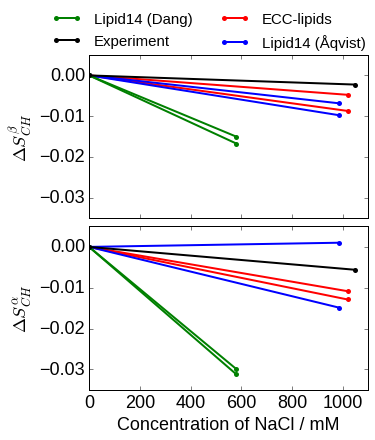

In [143]:
font = {'family' : 'Liberation Sans',
        'style'  : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig, axs = plt.subplots(nrows=2, ncols=1, 
                        sharex="all", figsize=[5,6], 
                        dpi=200)
fig.subplots_adjust(hspace=0.05)#fig.subplotpars.left = 0.3

# give subplots human-redable names
dsa = axs[1] # Delta S alpha
dsb = axs[0] # Delta S beta
pna = axs[1] # PN_vector

# add some text for labels, title and axes ticks
pna.set_xlabel(r'Concentration of NaCl / mM')
pna.set_ylabel(r'P-N angle')
dsa.set_ylabel(r'$\Delta S_{CH} ^{\alpha}$')
dsb.set_ylabel(r'$\Delta S_{CH} ^{\beta}$')

#pna.set_xlim([0.0,60.0])
#ax.set_xticks(r1)
#xlabelsl = list(xlabels)
#xlabelsl.extend(range(2, 18))
#ax.set_xticklabels(xlabelsl, rotation=0)

for (opsplot, c, label) in zip([opsdata, opsdata_l14, opsdata_l14d, experiments], 
                               ["red", "blue", "green", "black"], 
                               ["ECC-lipids", ur"Lipid14 (\u00c5qvist)", "Lipid14 (Dang)", "Experiment"]):
    for key in opsplot.keys():
        yerror = 0.001
        do_delta = False
        if key.startswith("alpha"):
            iplt = 1
            do_delta = True
            ylim = [-0.035, 0.005]
        elif key.startswith("beta"):
            iplt = 0
            do_delta = True
            ylim = [-0.035, 0.005]
        else:
            print "this should not happen, setting iplt = 1 \n Key name was {}".format(key)
            iplt = 1
        ax = axs[iplt]
        ax.set_ylim(ylim)
        if isinstance(opsplot[key], list):
            opsplot[key].sort()
        else:
            #print "this is not list, not sorting. It's likely the experimental data."
            pass
        data = np.array(opsplot[key])
        if do_delta:
            data[:,1] -= data[0,1]
        #ax.errorbar(data[:,0], data[:,1], yerr=yerror, lw=2.0, marker='s', markersize=5, mew=0, color=c) #, c=colour, lw=1.0, label=point_label)
        if key.startswith("alpha1") or key=="alpha":
            plot_label = label
        else:
            plot_label = None
        ax.plot(data[:,0], data[:,1], lw=2.0, marker='o', markersize=5, mew=0, color=c, label=plot_label) #, c=colour, lw=1.0, label=point_label)

        
for ax in axs:
    #ax.minorticks_on()
    pass
    
xlim = pna.get_xlim()
ticks = range(0, 1200, 200)
pna.set_xticks(ticks)
pna.set_xticklabels([ str(i) for i in ticks])
pna.set_xlim(0,1100)

#dsb.legend(loc="lower right", ncol=1, markerscale=1.0, scatterpoints=4, fontsize='xx-small')
dsa.legend(bbox_transform=plt.gcf().transFigure,
           bbox_to_anchor=(0.45, 1.03), 
           ncol=2, mode="expand",
           frameon=False,
           fontsize='small')

plt.savefig("OrdPars-A-B_L14-ECCL17_q80_sig89_NaCl.pdf", dpi=200, bbox_inches='tight')
plt.show()
